# 写入数据

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import csv
import xgboost as xgb
import numpy as np
import pandas as pd
import os


from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from xgboost import plot_importance
from matplotlib import pyplot


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# 链接：https://www.jianshu.com/p/7e0e2d66b3d4
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn import preprocessing
import datetime

from sklearn.metrics import log_loss

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans

import _thread
import time
from sklearn.preprocessing import LabelEncoder
start = time.time()


# ads = pd.read_csv('./train_clean.csv')
ads = pd.read_csv('./round1_ijcai_18_train_20180301.csv')
ads.head(2)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4006,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4001,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0


In [ ]:
pd.set_option('display.max_columns', None)

# 下面进行一些feature engineering  后面换数据集的话，注意调整topN的阀值

In [3]:
###################################          #itemid TopN          ##########################################


gp = ads.groupby(by='item_id')
newdf=gp.size().reset_index(name='times') 

pop_brands_low = newdf[newdf['times']<=200]['item_id'].unique()     #选100还是200


def itemid_cvt(num):
    if num in pop_brands_low:
        return 1

    else:
        return num

    
ads['item_id'] = ads['item_id'].apply(itemid_cvt)

le = LabelEncoder()
le.fit(ads['item_id'])
ads['item_id'] = le.transform(ads['item_id'])

In [4]:
###################################           #brand TopN       ##########################################
gp = ads.groupby(by='item_brand_id')
newdf=gp.size().reset_index(name='times') 

pop_brands_low = newdf[newdf['times']<=20]['item_brand_id'].unique()


def brand_cvt(num):
    if num in pop_brands_low:
        return 1

    else:
        return num

    
ads['item_brand_id'] = ads['item_brand_id'].apply(brand_cvt)

le = LabelEncoder()
le.fit(ads['item_brand_id'])
ads['item_brand_id'] = le.transform(ads['item_brand_id'])

In [5]:
###################################           #city TopN       ##########################################


gp = ads.groupby(by='item_city_id')
newdf=gp.size().reset_index(name='times') 
# newdf[newdf['times']>100].shape[0] #这个100是可以调整的 

pop_brands_low = newdf[newdf['times']<=50]['item_city_id'].unique()


def city_cvt(num):
    if num in pop_brands_low:
        return 1

    else:
        return num

    
ads['item_city_id'] = ads['item_city_id'].apply(city_cvt)

le = LabelEncoder()
le.fit(ads['item_city_id'])
ads['item_city_id'] = le.transform(ads['item_city_id'])

In [6]:
###################################           新特征len_predcat       ##########################################

#再对对item_property_list进行长度分析
#看每一行长度,越长表明本行越长，商品信息越丰富
df = ads['predict_category_property'].str.split(';',expand=True)
df.columns = ["len_"+str (i) for i in range(len(df.columns))]
ads.insert(20, 'len_pred_cat', df.count(axis=1) )
ads.head(1)


,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,predict_category_property,shop_id,len_pred_cat,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade
0,108641074714126964,0,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,225,33,3,3,4,14,...,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,5,4,1.0,5002,1.0,1.0,1.0,0


# 上面是新加特征

In [7]:
########################################          Timestamp      ############################################



def timestamp_datetime(value):
    format = '%Y-%m-%d %H:%M:%S'
    value = time.localtime(value)
    dt = time.strftime(format, value)
    return dt


def convert_data(data):
    data['time'] = data.context_timestamp.apply(timestamp_datetime)
    data['day'] = data.time.apply(lambda x: int(x[8:10]))
    data['hour'] = data.time.apply(lambda x: int(x[11:13]))
    user_query_day = data.groupby(['user_id', 'day']).size(
    ).reset_index().rename(columns={0: 'user_query_day'})
    data = pd.merge(data, user_query_day, 'left', on=['user_id', 'day'])
    user_query_day_hour = data.groupby(['user_id', 'day', 'hour']).size().reset_index().rename(
        columns={0: 'user_query_day_hour'})
    data = pd.merge(data, user_query_day_hour, 'left',
                    on=['user_id', 'day', 'hour'])
    
    return data

ads = convert_data(ads)
ads.head(2)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,time,day,hour,user_query_day,user_query_day_hour
0,108641074714126964,0,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,225,33,3,3,4,14,...,5002,1.0,1.0,1.0,0,2018-09-17 22:09:04,17,22,3,3
1,5754713551599725161,0,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,225,33,3,3,4,14,...,5002,1.0,1.0,1.0,0,2018-09-18 00:00:32,18,0,9,5


In [7]:
# def bin_time(num):
#     if num in [13,14,15,16,17,18]:
#         num=14
#     elif num in[19,20]:
#         num=15
#     elif num in [21, 22,23]:
#         num =num-5
#     else:
#         num = num +1
#     return num

# ads['context_timestamp'] = ads['context_timestamp'].apply(bin_time)
# ads['context_timestamp'].unique()

In [8]:
#对时间进行bin操作

# def bin_time(num):
#     if num in [13,14,15,16,17,18]:
#         num=14
#     elif num in[19,20]:
#         num=15
#     elif num in [21, 22,23]:
#         num =num-5
#     else:
#         num = num +1
#     return num

# ads['context_timestamp'] = ads['context_timestamp'].apply(bin_time)
# ads['context_timestamp'].unique()


# ###在这里创建新特征compare_cate:如果该item在后面pred出现，赋值为1,否则为0


# ads['item_category_list'] = ads['item_category_list'].apply(str)

# def compare_category(row):
#     if row['item_category_list'] in row['predict_category_property']:
#         return 1
#     else:
#         return 0

    
# compare_categ = ads.apply(compare_category, axis=1)
# ads.insert(14, 'compare_category', compare_categ)
# ads.head(2)


# ###在这里创建新特征compare_ppt:对于每个后面的predict_category_property，若出现x个在item_property_list，那么就x*weight来赋值
# #先分解item_property_list 
# import time
# s=time.time()


# df = ads['item_property_list'].str.split(';',expand=True)

# #存储新feature
# temp = pd.DataFrame(np.zeros((df.shape[0],1), dtype=int), columns=['compare_ppt'])
# for i in range(0, df.shape[0]):
#     a=0
#     for j in range(0, df.shape[1]):
#         if df.loc[i, j] is None:
#             pass
#         elif df.loc[i, j] not in ads.loc[i,'predict_category_property']:
#             pass
        
#         else:
#             a = a+1

#     temp.loc[i, 'compare_ppt'] = a


# ####插入新feature
# ads.insert(15, 'compare_ppt', temp['compare_ppt'])

# e=time.time()
# print(e-s)
# ads.head(2)

In [9]:
##########这个model特别在于跨表格交互项,和上面#删除item_category_list，item_property_list
#自身的特征处理与交互项的设计，之后全部扔进模型，判断importance


"""
0.853855125781 	 item_collected_level 	 item_sales_level
0.757697254859 	 item_pv_level 	 item_sales_level
0.672120340537 	 item_pv_level 	 item_collected_level
0.999464268562 	 user_occupation_id 	 user_age_level
0.999459654776 	 user_star_level 	 user_age_level
0.999683898893 	 user_star_level 	 user_occupation_id
0.463273190264 	 shop_review_num_level 	 item_sales_level
0.496431056543 	 shop_review_num_level 	 item_collected_level
0.459292574948 	 shop_star_level 	 item_sales_level
0.495633526375 	 shop_star_level 	 item_collected_level
0.986986984301 	 shop_star_level 	 shop_review_num_level
0.994215577652 	 shop_score_delivery 	 shop_score_service
0.46575561048 	 shop_score_description 	 shop_review_positive_rate
0.938355193265 	 shop_score_description 	 shop_score_service
0.931127706876 	 shop_score_description 	 shop_score_delivery
"""

###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################

'\n0.853855125781 \t item_collected_level \t item_sales_level\n0.757697254859 \t item_pv_level \t item_sales_level\n0.672120340537 \t item_pv_level \t item_collected_level\n0.999464268562 \t user_occupation_id \t user_age_level\n0.999459654776 \t user_star_level \t user_age_level\n0.999683898893 \t user_star_level \t user_occupation_id\n0.463273190264 \t shop_review_num_level \t item_sales_level\n0.496431056543 \t shop_review_num_level \t item_collected_level\n0.459292574948 \t shop_star_level \t item_sales_level\n0.495633526375 \t shop_star_level \t item_collected_level\n0.986986984301 \t shop_star_level \t shop_review_num_level\n0.994215577652 \t shop_score_delivery \t shop_score_service\n0.46575561048 \t shop_score_description \t shop_review_positive_rate\n0.938355193265 \t shop_score_description \t shop_score_service\n0.931127706876 \t shop_score_description \t shop_score_delivery\n'

In [8]:
# #item几个bin特征工程

# #bin操作item_sales_level  0,1-5,6,7,...,14,15-17
def bin_sales(num):
    if num in [1,2,3,4,5]:
        num=3
    elif num in[15,16,17]:
        num =16
    elif num == 0:
        num = 1
    else:
        num = num
    return num
ads['item_sales_level'] = ads['item_sales_level'].apply(bin_sales)

In [9]:
# # item_collected_level   0-2, 3-5, 6-8, 9, 10, ...,15, 16-17
def bin_collected(num):
    if num in [0,1,2]:
        num=1
    elif num in[3,4,5]:
        num =2
    elif num in [6,7,8]:
        num = 3
    elif num in [16,17]:
        num = 11
    else:
        num = num-5
    return num


ads['item_collected_level'] = ads['item_collected_level'].apply(bin_collected)

In [11]:
#################################     对item_property_list 进行聚类     ######################################

#用item_property_list列生成新的数据集，用于聚类
df = ads['item_property_list'].str.split(';',expand=True)
df.columns = ["property_"+str (i) for i in range(len(df.columns))]
df = df.fillna(-1)

#把string格式转换成integer格式来运行聚类算法
def toInt(raw_str):
    return int(raw_str)

temp_x = [df[df.columns[i]].apply(toInt) for i in range(len(df.columns))]

#把dataframe变成array作为聚类算法的输入
item_property_list = pd.concat(temp_x, axis=1)
X = item_property_list.as_matrix()

#商品总共14个类别，所以针对property取14个cluster
kmeans = KMeans(n_clusters=14)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
ads.insert(22, 'property_label', labels)
ads.shape

(477147, 34)

这里直接split然后取list的长度就会快很多，不需要转化成df再数再insert

In [16]:
#########################   item_property_list进行长度分析     #############################################
#看每一行长度,越长表明本行越长，商品信息越丰富
# df = ads['item_property_list'].str.split(';',expand=True)    #---  takes too long to run
# df.columns = ["property_"+str (i) for i in range(len(df.columns))]
# ads.insert(20, 'len_property', df.count(axis=1) )

ads['test_len'] = ads['item_property_list'].str.split(';',expand=False).apply( lambda x: len(x))
ads.head(1)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,len_property,len_pred_cat,shop_review_num_level,property_label,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,time,day,hour,user_query_day,user_query_day_hour
0,108641074714126964,0,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,225,33,3,3,2,14,4505772604969228686,1,1003,2005,3003,282924576738839389,1537236544,4006,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,22,5,4,4,1.0,5002,1.0,1.0,1.0,0,2018-09-17 22:09:04,17,22,3,3


In [27]:
################################      label   item_category_list     ###################################
#函数用来分解item_category_list
def split_fst(str1= None):
    """
    this is to split the combined attributes
    """
    if ';' not in str1:
        return str1
    else:
        pos = str1.index(';')
        return str1[:pos]


def split_snd(str1 = None):
    """
    this is to split the combined attributes
    """
    if ';' not in str1:
        return str1
    else:
        pos = str1.index(';')
        return str1[pos+1:]


ads['item_category_list'] = ads['item_category_list'].apply(split_snd)
ads['item_category_list'] = ads['item_category_list'].apply(split_snd)
ads['item_category_list'] = ads['item_category_list'].apply(lambda x: int(x))
ads['item_category_list'].unique() 



#对category进行label encoder
le = LabelEncoder()
le.fit(ads['item_category_list'].unique())
ads['item_category_list'] = le.transform(ads['item_category_list'])


# 下面开始建模

In [28]:
X = ads[['item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level',
        'context_page_id',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'property_label','len_property',  'shop_star_level', 'shop_score_service',
       'shop_score_delivery', 'shop_score_description',
        'hour', 'user_query_day', 'user_query_day_hour','len_pred_cat']]
Y = ads[['is_trade']]
Y.head(2)

,is_trade
0,0
1,0


In [29]:
seed = 7
test_size = 0.25
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [30]:
##################################     #模型调参主要地方           #####################################
# 黄金搭档：
# learning_rate = 0.05  0.1
# max_depth = 6  7
# n_estimators = 500  500

def xgb_model(train_data, train_label, test_data, test_label):
    clf = XGBClassifier(max_depth=6,
                           min_child_weight=1,
                           learning_rate=0.02,
                           n_estimators=500,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)
    
    clf.fit(train_data, train_label, eval_metric='logloss', verbose=True,
            eval_set=[(test_data, test_label)], early_stopping_rounds=100)
#     Y_pre = clf.predict(test_data)
    Y_pro = clf.predict_proba(test_data)[:, 1]

    return clf


[0]	validation_0-logloss:0.674793
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.657159
[2]	validation_0-logloss:0.640205
[3]	validation_0-logloss:0.623893
[4]	validation_0-logloss:0.608187
[5]	validation_0-logloss:0.593057
[6]	validation_0-logloss:0.578473
[7]	validation_0-logloss:0.564409
[8]	validation_0-logloss:0.550837
[9]	validation_0-logloss:0.537735
[10]	validation_0-logloss:0.52508
[11]	validation_0-logloss:0.512853
[12]	validation_0-logloss:0.501032
[13]	validation_0-logloss:0.4896
[14]	validation_0-logloss:0.478541
[15]	validation_0-logloss:0.467836
[16]	validation_0-logloss:0.457473
[17]	validation_0-logloss:0.447436
[18]	validation_0-logloss:0.437712
[19]	validation_0-logloss:0.428289
[20]	validation_0-logloss:0.419154
[21]	validation_0-logloss:0.410297
[22]	validation_0-logloss:0.401706
[23]	validation_0-logloss:0.393373
[24]	validation_0-logloss:0.385285
[25]	validation_0-logloss:0.377436
[26]	validation_0-logloss:0.369816

[230]	validation_0-logloss:0.089042
[231]	validation_0-logloss:0.089014
[232]	validation_0-logloss:0.088982
[233]	validation_0-logloss:0.088951
[234]	validation_0-logloss:0.088921
[235]	validation_0-logloss:0.088891
[236]	validation_0-logloss:0.088862
[237]	validation_0-logloss:0.088834
[238]	validation_0-logloss:0.08881
[239]	validation_0-logloss:0.088783
[240]	validation_0-logloss:0.088756
[241]	validation_0-logloss:0.088728
[242]	validation_0-logloss:0.088703
[243]	validation_0-logloss:0.08868
[244]	validation_0-logloss:0.088657
[245]	validation_0-logloss:0.088636
[246]	validation_0-logloss:0.088612
[247]	validation_0-logloss:0.08859
[248]	validation_0-logloss:0.088568
[249]	validation_0-logloss:0.088551
[250]	validation_0-logloss:0.088532
[251]	validation_0-logloss:0.088513
[252]	validation_0-logloss:0.088493
[253]	validation_0-logloss:0.088475
[254]	validation_0-logloss:0.088457
[255]	validation_0-logloss:0.088439
[256]	validation_0-logloss:0.088424
[257]	validation_0-logloss:0.08

[459]	validation_0-logloss:0.087615
[460]	validation_0-logloss:0.087614
[461]	validation_0-logloss:0.087614
[462]	validation_0-logloss:0.087614
[463]	validation_0-logloss:0.087615
[464]	validation_0-logloss:0.087616
[465]	validation_0-logloss:0.087615
[466]	validation_0-logloss:0.087617
[467]	validation_0-logloss:0.087618
[468]	validation_0-logloss:0.087617
[469]	validation_0-logloss:0.087617
[470]	validation_0-logloss:0.087617
[471]	validation_0-logloss:0.087616
[472]	validation_0-logloss:0.087616
[473]	validation_0-logloss:0.087616
[474]	validation_0-logloss:0.087616
[475]	validation_0-logloss:0.087615
[476]	validation_0-logloss:0.087614
[477]	validation_0-logloss:0.087615
[478]	validation_0-logloss:0.087615
[479]	validation_0-logloss:0.087614
[480]	validation_0-logloss:0.087612
[481]	validation_0-logloss:0.087612
[482]	validation_0-logloss:0.087613
[483]	validation_0-logloss:0.087612
[484]	validation_0-logloss:0.087611
[485]	validation_0-logloss:0.087611
[486]	validation_0-logloss:0

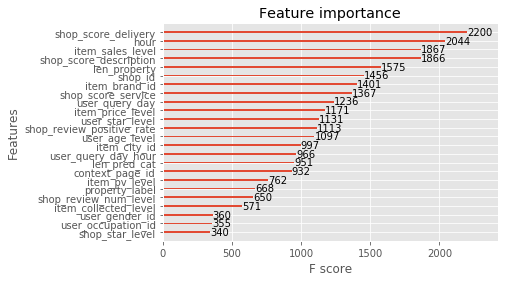

In [31]:
model_all = xgb_model(X_train,Y_train, X_test,  Y_test)

plot_importance(model_all)   #feature重要程度
pyplot.show()

# Lasso Regression

In [60]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [65]:
ads_test = ads.sample(frac=0.2)

X_l = ads_test[['item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level',
        'context_page_id',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'property_label','len_property',  'shop_star_level', 'shop_score_service',
       'shop_score_delivery', 'shop_score_description',
        'hour', 'user_query_day', 'user_query_day_hour','len_pred_cat']]
Y_l = ads_test[['is_trade']]

seed = 7
test_size = 0.25
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_l, Y_l, test_size=test_size, random_state=seed)



lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)


In [66]:
clf.fit(X_train1,Y_train1)

GridSearchCV(cv=3, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

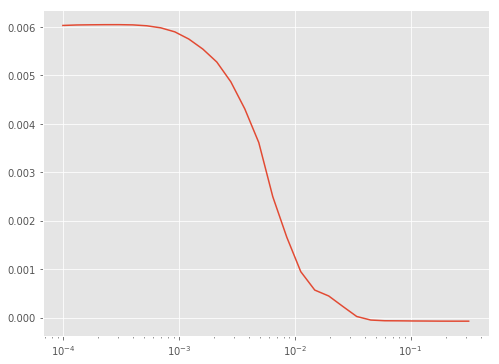

In [67]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

In [88]:
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)


seed = 7
test_size = 0.25
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_l, Y_l, test_size=test_size, random_state=seed)

lasso = Lasso(alpha=.003)

lasso.fit(X_train1, Y_train1)
  
print ("Lasso model: ", pretty_print_linear(lasso.coef_, names=None, sort = True))


Lasso model:  -0.004 * X2 + 0.001 * X3 + -0.001 * X22 + -0.0 * X21 + -0.0 * X12 + 0.0 * X20 + 0.0 * X7 + -0.0 * X10 + 0.0 * X15 + -0.0 * X1 + -0.0 * X0 + -0.0 * X11 + -0.0 * X4 + -0.0 * X5 + 0.0 * X6 + -0.0 * X8 + 0.0 * X9 + -0.0 * X13 + -0.0 * X14 + -0.0 * X16 + -0.0 * X17 + -0.0 * X18 + -0.0 * X19 + 0.0 * X23


In [101]:
def lasso(alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    df = pd.DataFrame()
    
    # Create a column of feature names
    df['Feature Name'] = X_train1.columns
    
    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)
        
        # Fit the lasso regression
        lasso.fit(X_train1, Y_train1)
        
        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        df[column_name] = lasso.coef_
        print(lasso.score(X_train1, Y_train1))
    # Return the datafram    
    return df

lasso([.0001, .001, .01,.1])

0.0067532701610794055
0.0064999544422497104
0.00155327923589621
3.604534355128308e-05


,Feature Name,Alpha = 0.000100,Alpha = 0.001000,Alpha = 0.010000,Alpha = 0.100000
0,item_brand_id,-2.891139e-06,-2.976878e-06,-2.060906e-06,-6.895974e-07
1,item_city_id,-7.654495e-06,-2.081594e-05,-8.414619e-05,-0.000000e+00
2,item_price_level,-5.510769e-03,-5.065257e-03,-0.000000e+00,-0.000000e+00
3,item_sales_level,3.819803e-03,2.708938e-03,2.972932e-04,0.000000e+00
4,item_collected_level,-1.586354e-03,-7.694463e-04,0.000000e+00,0.000000e+00
5,item_pv_level,-1.064011e-03,-4.659270e-04,0.000000e+00,0.000000e+00
6,user_gender_id,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
7,user_age_level,2.097080e-03,1.549007e-03,0.000000e+00,0.000000e+00
8,user_occupation_id,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
9,user_star_level,4.368419e-04,2.097788e-04,0.000000e+00,0.000000e+00


In [110]:
len(y_test)

23858

In [ ]:
model = make_pipeline(PolynomialFeatures(2, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
model.fit(X_train,y_train)
test_pred = np.array(model.predict(X_test))
# RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
test_score = model.score(X_test,y_test)

In [106]:
# Import function to create training and test set splits
from sklearn.cross_validation import train_test_split
# Import function to automatically create polynomial features! 
from sklearn.preprocessing import PolynomialFeatures
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
# Finally, import function to make a machine learning pipeline
from sklearn.pipeline import make_pipeline


# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000
# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8
# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X_l, Y_l, test_size=test_size, random_state=seed)
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)

ValueError: Shape of passed values is (23858, 23858), indices imply (1, 23858)

In [53]:
cor = ads.corr()
columns= list(cor.columns.values)
# for i in ads.corr():
#     print(i)

In [54]:
for i in range(cor.shape[0]):
    for j in range(i+1):
        if cor.iloc[i,j]!=1 and cor.iloc[i,j]>0.8 or cor.iloc[i,j]<-0.8:
            print(cor.iloc[i,j],'\t', columns[i],'\t', columns[j])

0.8354561841804006 	 item_collected_level 	 item_sales_level
0.9869940671504477 	 shop_star_level 	 shop_review_num_level
0.9941417041149618 	 shop_score_delivery 	 shop_score_service
0.9376561305553119 	 shop_score_description 	 shop_score_service
0.9303513146718432 	 shop_score_description 	 shop_score_delivery
0.989787409122976 	 day 	 context_timestamp


In [34]:
#修改为logloss而不是0 1
Y_pred = model_all.predict_proba(X_test)
print("--"*50)
print("--"*50)
print(log_loss(Y_test, Y_pred))
print("--"*50)
print("--"*50)

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
0.08760849308065373
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


# 开始测试，先输入数据和特征工程

In [36]:
# 这里输入我们的test文件， 这样最后能形成一个output file
submission_test = pd.read_csv('./round1_ijcai_18_test_a_20180301.txt', sep=" ")

submission_test.head(2)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description
0,2475218615076601065,2275895163219263378,7908382889764677758;8277336076276184272,2636395404473730413;7515802706813700848;302719...,7838285046767229711,7534238860363577544,7,6,8,14,...,1537885700,4005,8277336076276184272:-1;5799347067982556520:-1;...,5275548996133547595,13,0.985244,5011,0.964023,0.966550,0.955378
1,398316874173557226,7096238490711246967,7908382889764677758;5755694407684602296,5131280576272319091;2636395404473730413;734498...,8126195666233054089,3948283326616421003,6,9,8,16,...,1537862843,4001,"5755694407684602296:216555019471416386,2636395...",329470548383752413,14,0.989068,5012,0.963794,0.964225,0.959134


In [37]:
###################################          #itemid TopN          ##########################################


gp = submission_test.groupby(by='item_id')
newdf=gp.size().reset_index(name='times') 

pop_brands_low = newdf[newdf['times']<=200]['item_id'].unique()     #选100还是200


def itemid_cvt(num):
    if num in pop_brands_low:
        return 1

    else:
        return num

    
submission_test['item_id'] = submission_test['item_id'].apply(itemid_cvt)

le = LabelEncoder()
le.fit(submission_test['item_id'])
submission_test['item_id'] = le.transform(submission_test['item_id'])

In [38]:
###################################           #brand TopN       ##########################################
gp = submission_test.groupby(by='item_brand_id')
newdf=gp.size().reset_index(name='times') 

pop_brands_low = newdf[newdf['times']<=20]['item_brand_id'].unique()


def brand_cvt(num):
    if num in pop_brands_low:
        return 1

    else:
        return num

    
submission_test['item_brand_id'] = submission_test['item_brand_id'].apply(brand_cvt)

le = LabelEncoder()
le.fit(submission_test['item_brand_id'])
submission_test['item_brand_id'] = le.transform(submission_test['item_brand_id'])

In [39]:
###################################           #city TopN       ##########################################


gp = submission_test.groupby(by='item_city_id')
newdf=gp.size().reset_index(name='times') 

pop_brands_low = newdf[newdf['times']<=50]['item_city_id'].unique()


def city_cvt(num):
    if num in pop_brands_low:
        return 1

    else:
        return num

    
submission_test['item_city_id'] = submission_test['item_city_id'].apply(city_cvt)

le = LabelEncoder()
le.fit(submission_test['item_city_id'])
submission_test['item_city_id'] = le.transform(submission_test['item_city_id'])

In [40]:
###################################           新特征len_predcat       ##########################################

#再对对item_property_list进行长度分析
#看每一行长度,越长表明本行越长，商品信息越丰富
df = submission_test['predict_category_property'].str.split(';',expand=True)
df.columns = ["len_"+str (i) for i in range(len(df.columns))]
submission_test.insert(20, 'len_pred_cat', df.count(axis=1) )

In [41]:
##############################################################

#timestamp

def timestamp_datetime(value):
    format = '%Y-%m-%d %H:%M:%S'
    value = time.localtime(value)
    dt = time.strftime(format, value)
    return dt


def convert_data(data):
    data['time'] = data.context_timestamp.apply(timestamp_datetime)
    data['day'] = data.time.apply(lambda x: int(x[8:10]))
    data['hour'] = data.time.apply(lambda x: int(x[11:13]))
    user_query_day = data.groupby(['user_id', 'day']).size(
    ).reset_index().rename(columns={0: 'user_query_day'})
    data = pd.merge(data, user_query_day, 'left', on=['user_id', 'day'])
    user_query_day_hour = data.groupby(['user_id', 'day', 'hour']).size().reset_index().rename(
        columns={0: 'user_query_day_hour'})
    data = pd.merge(data, user_query_day_hour, 'left',
                    on=['user_id', 'day', 'hour'])
    
    return data

submission_test = convert_data(submission_test)
submission_test.head(2)


# #item几个bin特征工程



,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,time,day,hour,user_query_day,user_query_day_hour
0,2475218615076601065,0,7908382889764677758;8277336076276184272,2636395404473730413;7515802706813700848;302719...,162,22,7,6,8,14,...,0.985244,5011,0.964023,0.966550,0.955378,2018-09-25 10:28:20,25,10,2,2
1,398316874173557226,0,7908382889764677758;5755694407684602296,5131280576272319091;2636395404473730413;734498...,0,12,6,9,8,16,...,0.989068,5012,0.963794,0.964225,0.959134,2018-09-25 04:07:23,25,4,2,2


In [42]:
# #bin操作item_sales_level  0,1-5,6,7,...,14,15-17
def bin_sales(num):
    if num in [1,2,3,4,5]:
        num=3
    elif num in[15,16,17]:
        num =16
    elif num == 0:
        num = 1
    else:
        num = num
    return num
submission_test['item_sales_level'] = submission_test['item_sales_level'].apply(bin_sales)

In [43]:
# # item_collected_level   0-2, 3-5, 6-8, 9, 10, ...,15, 16-17
def bin_collected(num):
    if num in [0,1,2]:
        num=1
    elif num in[3,4,5]:
        num =2
    elif num in [6,7,8]:
        num = 3
    elif num in [16,17]:
        num = 11
    else:
        num = num-5
    return num


submission_test['item_collected_level'] = submission_test['item_collected_level'].apply(bin_collected)

In [44]:
#对item_property_list 进行聚类
#用item_property_list列生成新的数据集，用于聚类
df = submission_test['item_property_list'].str.split(';',expand=True)
df.columns = ["property_"+str (i) for i in range(len(df.columns))]
df = df.fillna(-1)

#把string格式转换成integer格式来运行聚类算法
def toInt(raw_str):
    return int(raw_str)

temp_x = [df[df.columns[i]].apply(toInt) for i in range(len(df.columns))]

#把dataframe变成array作为聚类算法的输入
item_property_list = pd.concat(temp_x, axis=1)
X = item_property_list.as_matrix()

#商品总共14个类别，所以针对property取14个cluster
kmeans = KMeans(n_clusters=100)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
submission_test.insert(22, 'property_label', labels)
submission_test.shape

(18371, 33)

In [45]:
#再对对item_property_list进行长度分析
#看每一行长度,越长表明本行越长，商品信息越丰富
df = submission_test['item_property_list'].str.split(';',expand=True)
df.columns = ["property_"+str (i) for i in range(len(df.columns))]
submission_test.insert(20, 'len_property', df.count(axis=1) )
submission_test.head(1)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,time,day,hour,user_query_day,user_query_day_hour
0,2475218615076601065,0,7908382889764677758;8277336076276184272,2636395404473730413;7515802706813700848;302719...,162,22,7,6,3,14,...,0.985244,5011,0.964023,0.96655,0.955378,2018-09-25 10:28:20,25,10,2,2


In [46]:
# #函数用来分解item_category_list
def split_fst(str1= None):
    """
    this is to split the combined attributes
    """
    if ';' not in str1:
        return str1
    else:
        pos = str1.index(';')
        return str1[:pos]


def split_snd(str1 = None):
    """
    this is to split the combined attributes
    """
    if ';' not in str1:
        return str1
    else:
        pos = str1.index(';')
        return str1[pos+1:]


submission_test['item_category_list'] = submission_test['item_category_list'].apply(split_snd)
submission_test['item_category_list'] = submission_test['item_category_list'].apply(split_snd)
submission_test['item_category_list'] = submission_test['item_category_list'].apply(lambda x: int(x))
submission_test['item_category_list'].unique() 


#对category进行label encoder
le = LabelEncoder()
le.fit(submission_test['item_category_list'].unique())
submission_test['item_category_list'] = le.transform(submission_test['item_category_list'])



In [49]:
features = ['item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level',
        'context_page_id',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'property_label','len_property',  'shop_star_level', 'shop_score_service',
       'shop_score_delivery', 'shop_score_description',
        'hour', 'user_query_day', 'user_query_day_hour','len_pred_cat']

In [50]:
sub_pred = model_all.predict_proba(submission_test[features])[:, 1]
submission_test['predicted_score'] = sub_pred
submission_test[['instance_id', 'predicted_score']].to_csv('./model_all.txt', index=False, sep=' ')

In [51]:
hh = pd.read_csv('./model_all.txt', sep=' ')
hh.head(2)

,instance_id,predicted_score
0,2475218615076601065,0.011258
1,398316874173557226,0.031412


In [52]:
pd.read_csv('./round1_ijcai_18_result_demo_20180301.txt', sep=' ')

,instance_id,predicted_score
0,2475218615076601065,0.9
1,398316874173557226,0.7
2,6586402638209028583,0.5
3,1040996105851528465,0.3
4,6316278569655873454,0.1


In [ ]:
################################################################################################################
#####################################        生成与提交test结果          ############################################## 


# 这里重新写！！！


# 这里输入我们的test文件， 这样最后能形成一个output file
# sub_test = pd.read_csv('./round1_ijcai_18_test_a_20180301.txt', sep=" ")
# del sub_test['item_property_list']
# del sub_test['item_category_list']
# del sub_test['predict_category_property']
# temp = sub_test.iloc[:,[2,3,4,5,6,7,9,10,11,12,14,15,17,18,19,20,21,22]]
# temp.head(2)


###出结果！！！

In [ ]:
# sub_pred = model_all.predict_proba(temp)[:, 1]
# sub_test['predicted_score'] = sub_pred
# sub_test[['instance_id', 'predicted_score']].to_csv('model_all.csv', index=False,sep=' ')
# #保存在线提交结果

In [ ]:
# model_item = XGBClassifier()  #建模

# #调参：最佳学习率
# learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
# param_grid = dict(learning_rate=learning_rate)
# kfold = StratifiedKFold(n_splits=12, shuffle=True, random_state=7)

# #使用grid_search, 一般还有random search（最后结果可能稍逊，但是时间省太太太多）
# grid_search = GridSearchCV(model_item, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X, Y)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


# eval_set = [(X_test, Y_test)]
# model_item.fit(X_train, Y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=True)
# #here logloss
# #we use auc to deal with imbalanced


# plot_importance(model_item)   #feature重要程度
# pyplot.show()